## HFS resolution study

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os
import math

import uproot3

rc('text', usetex=True)

import matplotlib as mpl

mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

ebeam_e = 27.6
ebeam_p = 920



#infile_name = 'mini-tree.root-save-2021-07-17a'
#infile_name = 'mini-tree-badres-10percent-constant.root'
#infile_name = 'mini-tree-badres-20percent-constant.root'
#infile_name = 'mini-tree-gen-HFS-etamax4.0.root'
#infile_name = 'mini-tree-nim-hcal-coverage.root'
#infile_name = 'mini-tree-nim-hcal2-towers-only-badres-at-edges-hcal-20percent-const.root'
#infile_name = 'mini-tree-noise-lm-0.0-ls-0.1-p1.0.root'

#infile_name = 'mini-tree-etamin0.96-edge-reso-bad--no-noise-500k.root'
#infile_name = 'mini-tree-etamin0.96-edge-reso-bad.root'
#infile_name = 'mini-tree.root'

infile_name = 'mini-tree-etamin0.96-edge-reso-bad-ls0.05-1m.root'



infile_name_fullsim = 'h1-fullsim-2021-07-19/h1fullsim-5files.root'







/Users/owen/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Read in the minitree root file into a pandas dataframe

In [2]:
print('\n Loading fastsim minitree\n')
ur_file = uproot3.open(infile_name)
print (ur_file.keys()) 
ur_tree = ur_file['minitree']
print(ur_tree)
mc   =  ur_tree.pandas.df(['*'], entrystop=3e7,flatten=True)
mc

print('\n Loading fullsim minitree\n')
ur_file_fullsim = uproot3.open(infile_name_fullsim)
print (ur_file_fullsim.keys())
print (ur_file_fullsim['Django'].keys())
ur_tree_fullsim = ur_file_fullsim['Django']['minitree']
print(ur_tree_fullsim)
mc_fullsim = ur_tree_fullsim.pandas.df(['*'], entrystop=3e7,flatten=True)

print('\n Done \n')


 Loading fastsim minitree

[b'minitree;5', b'minitree;4']
<TTree b'minitree' at 0x00010ef91040>

 Loading fullsim minitree

[b'Django;1']
[b'minitree;1', b'DISEvent;1']
<TTree b'minitree' at 0x00012d7081f0>

 Done 



### Do all of the calculations and save results as columns in the dataframe

In [3]:
def do_calculations( df ):
    
    temp = df

    temp['tan_theta_over_2__gen_e'] = np.tan( temp['gen_e_theta'] / 2. )
    temp['e_pt'] = np.sqrt( temp['e_px']*temp['e_px'] + temp['e_py']*temp['e_py'])
    temp['e_theta'] = np.arctan2( temp['e_pt'], temp['e_pz'])
    temp['tan_theta_over_2__rec_e'] = np.tan( temp['e_theta'] / 2. )
    
    temp.eval( 'tan_gamma_over_2__gen_e = tan_theta_over_2__gen_e * (gen_y/(1.-gen_y))', inplace=True)    
    
    
    
    temp.eval( 'dx_sigma_norm = (x_sigma - gen_x) / gen_x', inplace=True )    
    
    
    temp.eval( 'Sigma__HFS = HFS_E - HFS_pz', inplace=True )
    temp.eval( 'Sigma__gen_HFS = gen_HFS_e - gen_HFS_pz', inplace=True )    
    temp.eval( 'Sigma__gen_e = gen_y * (gen_e_e - gene_pz)/(1-gen_y)', inplace=True )
    
    temp.eval( 'dSigma_norm__gen_HFS = (Sigma__HFS - Sigma__gen_HFS) / Sigma__gen_HFS', inplace=True )   
    temp.eval( 'dSigma_norm__gen_e = (Sigma__HFS - Sigma__gen_e) / Sigma__gen_e', inplace=True )
    
    
    
        
    temp.eval( 'T__HFS = HFS_pt', inplace=True )
    
    temp.eval( 'T__gen_e = Sigma__gen_e / tan_gamma_over_2__gen_e', inplace=True )    
    temp.eval( 'dT_norm__gen_e = (T__HFS - T__gen_e) / T__gen_e', inplace=True )
    
    temp.eval( 'T__gen_HFS = gen_HFS_pt', inplace=True )
    temp.eval( 'dT_norm__gen_HFS = (T__HFS - T__gen_HFS) / T__gen_HFS', inplace=True )
    
    

    
    
    temp.eval( 'dHFS_pz_norm__gen_HFS = (HFS_pz - gen_HFS_pz) / gen_HFS_pz', inplace=True )
    
    temp.eval( 'dHFS_E_norm__gen_HFS = (HFS_E - gen_HFS_e) / gen_HFS_e', inplace=True)
    

    
    temp.eval( 'tan_gamma_over_2__HFS = Sigma__HFS / T__HFS', inplace=True )

    
    temp.eval( 'dtan_gamma_over_2_norm__gen_e = (tan_gamma_over_2__HFS - tan_gamma_over_2__gen_e) / tan_gamma_over_2__gen_e', inplace=True )
    
    temp = temp.query( 'HFS_pt>2')
    
    return temp
    

In [4]:
def do_calculations_fullsim( df ):
    
    temp = df

    temp.eval('gen_e_pt = sqrt(gene_px*gene_px + gene_py*gene_py)', inplace=True )
    temp.eval('gen_e_theta = arctan2( gen_e_pt, gene_pz)', inplace=True )
    
    
    temp['tan_theta_over_2__gen_e'] = np.tan( temp['gen_e_theta'] / 2. )
    temp['e_pt'] = np.sqrt( temp['e_px']*temp['e_px'] + temp['e_py']*temp['e_py'])
    temp['e_theta'] = np.arctan2( temp['e_pt'], temp['e_pz'])
    temp['tan_theta_over_2__rec_e'] = np.tan( temp['e_theta'] / 2. )
    
    temp.eval( 'tan_gamma_over_2__gen_e = tan_theta_over_2__gen_e * (gen_y/(1.-gen_y))', inplace=True)    

    temp.eval( 's = 4*27.6*920', inplace=True)
    temp.eval( 'gen_x = gen_Q2/(s*gen_y)', inplace=True)
    temp.eval( 'x_sigma = Q2_sigma/(s*y_sigma)',inplace=True)
    
    temp.eval( 'gen_HFS_e = genHFS_E', inplace=True)
    temp.eval( 'gen_HFS_px = genHFS_px', inplace=True)
    temp.eval( 'gen_HFS_py = genHFS_py', inplace=True)
    temp.eval( 'gen_HFS_pz = genHFS_pz', inplace=True)
    temp.eval( 'gen_HFS_pt = sqrt( genHFS_px*genHFS_px + genHFS_py*genHFS_py)', inplace=True )
    temp.eval( 'gen_e_e = sqrt( gene_px*gene_px + gene_py*gene_py + gene_pz*gene_pz)', inplace=True )
    temp.eval( 'HFS_pt = sqrt(HFS_px*HFS_px + HFS_py*HFS_py)', inplace=True )
    
    temp.eval( 'dx_sigma_norm = (x_sigma - gen_x) / gen_x', inplace=True )    
    
    
    temp.eval( 'Sigma__HFS = HFS_E - HFS_pz', inplace=True )
    temp.eval( 'Sigma__gen_HFS = gen_HFS_e - gen_HFS_pz', inplace=True )    
    temp.eval( 'Sigma__gen_e = gen_y * (gen_e_e - gene_pz)/(1-gen_y)', inplace=True )
    
    temp.eval( 'dSigma_norm__gen_HFS = (Sigma__HFS - Sigma__gen_HFS) / Sigma__gen_HFS', inplace=True )   
    temp.eval( 'dSigma_norm__gen_e = (Sigma__HFS - Sigma__gen_e) / Sigma__gen_e', inplace=True )
    
    
    
        
    temp.eval( 'T__HFS = HFS_pt', inplace=True )
    
    temp.eval( 'T__gen_e = Sigma__gen_e / tan_gamma_over_2__gen_e', inplace=True )
    temp.eval( 'dT_norm__gen_e = (T__HFS - T__gen_e) / T__gen_e', inplace=True )
    
    temp.eval( 'T__gen_HFS = gen_HFS_pt', inplace=True )
    temp.eval( 'dT_norm__gen_HFS = (T__HFS - T__gen_HFS) / T__gen_HFS', inplace=True )
    
    
    

    
    
    temp.eval( 'dHFS_pz_norm__gen_HFS = (HFS_pz - gen_HFS_pz) / gen_HFS_pz', inplace=True )
    
    temp.eval( 'dHFS_E_norm__gen_HFS = (HFS_E - gen_HFS_e) / gen_HFS_e', inplace=True)
    

    
    temp.eval( 'tan_gamma_over_2__HFS = Sigma__HFS / T__HFS', inplace=True )

    
    temp.eval( 'dtan_gamma_over_2_norm__gen_e = (tan_gamma_over_2__HFS - tan_gamma_over_2__gen_e) / tan_gamma_over_2__gen_e', inplace=True )
    
    temp = temp.query( 'Sigma__HFS>0')
    
    temp = temp.query( 'gen_Q2 > 200')
    
    return temp
    

In [5]:
mc = do_calculations( mc )

mc[['Sigma__HFS','Sigma__gen_HFS','Sigma__gen_e','dSigma_norm__gen_HFS','dSigma_norm__gen_e','dx_sigma_norm']]

,Sigma__HFS,Sigma__gen_HFS,Sigma__gen_e,dSigma_norm__gen_HFS,dSigma_norm__gen_e,dx_sigma_norm
entry,,,,,,
0,4.877010,5.276131,5.362240,-0.075646,-0.090490,-0.027397
1,23.767599,27.977901,27.996008,-0.150487,-0.151036,0.063035
2,2.886200,2.092361,2.136436,0.379398,0.350942,-0.366054
3,25.517109,29.007946,29.059019,-0.120341,-0.121887,-0.044164
4,16.477211,15.424429,15.524137,0.068254,0.061393,-0.058103
...,...,...,...,...,...,...
830528,2.470261,2.939308,2.957506,-0.159578,-0.164749,0.123763
830529,23.872009,20.749786,20.774731,0.150470,0.149089,0.092660
830530,2.781105,0.985062,1.057025,1.823280,1.631068,-0.563615


In [6]:
mc_fullsim = do_calculations_fullsim( mc_fullsim )

mc_fullsim[['Sigma__HFS','Sigma__gen_HFS','Sigma__gen_e','dSigma_norm__gen_HFS','dSigma_norm__gen_e','dx_sigma_norm']]

,Sigma__HFS,Sigma__gen_HFS,Sigma__gen_e,dSigma_norm__gen_HFS,dSigma_norm__gen_e,dx_sigma_norm
entry,,,,,,
9,4.865891,4.119385,4.119347,0.181218,0.181229,-0.161026
13,36.502609,34.189270,34.188122,0.067663,0.067699,0.098120
20,3.339027,6.274719,6.514610,-0.467860,-0.487456,0.568782
21,4.500389,2.772888,3.333112,0.622997,0.350206,-0.310145
22,34.220890,37.079468,37.078213,-0.077093,-0.077062,-0.107738
...,...,...,...,...,...,...
4963046,7.653818,8.815002,8.814899,-0.131728,-0.131718,0.175339
4963053,22.781120,23.408142,23.405525,-0.026786,-0.026678,-0.048808
4963056,10.346451,11.103699,11.103583,-0.068198,-0.068188,-0.035366


In [7]:
#cuts = 'gen_y > 0.01 and gen_y < 0.05'
cuts = 'gen_y < 0.7'

axis_max = 1.6

## compare different definitions of HFS_pt or T

In the fastsim, HFS_px and HFS_py are defined by a sum over MC particles including an |eta|<4 cut.  In the fullsim file, there's no |eta| cut.  That means that the gen_e and gen_HFS values of T are the same in fullsim but not in fastsim, where there's a resolution from finite geometric acceptance.  The gen_e definition is exact.



cuts : gen_y < 0.7


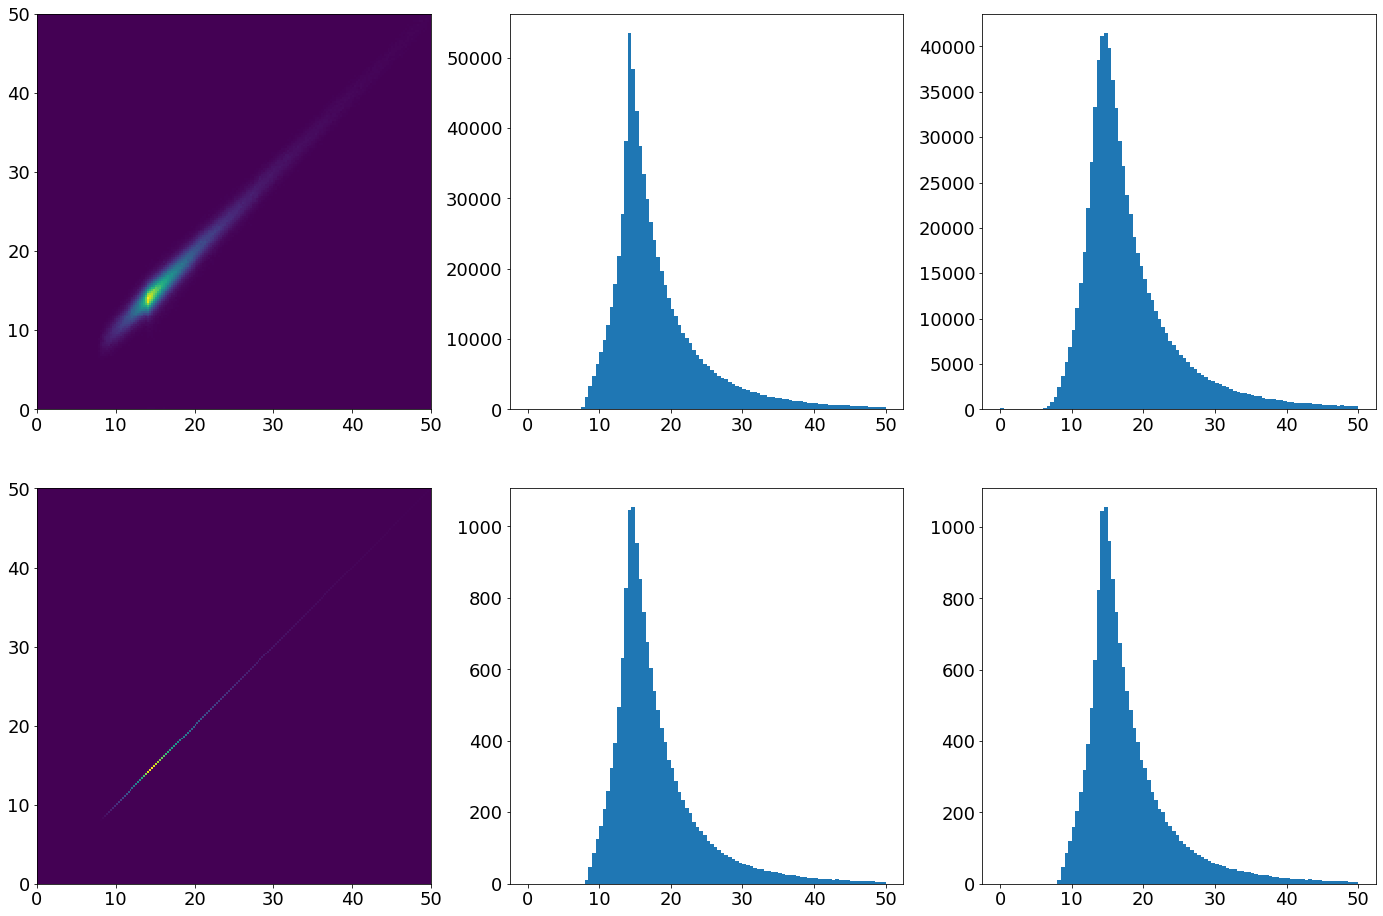

In [8]:
fig,ax = plt.subplots(2,3,figsize=(24,16))

print( 'cuts : %s' % cuts )

ax[0][0].hist2d( mc.query(cuts)['T__gen_e'], mc.query(cuts)['T__gen_HFS'], range=([0,50],[0,50]), bins=200)
ax[0][1].hist( mc.query(cuts)['T__gen_e'],range=[0,50], bins=100)
ax[0][2].hist( mc.query(cuts)['T__gen_HFS'],range=[0,50], bins=100)

ax[1][0].hist2d( mc_fullsim.query(cuts)['T__gen_e'], mc_fullsim.query(cuts)['T__gen_HFS'], weights=mc_fullsim.query(cuts)['wgt'], range=([0,50],[0,50]), bins=200)
ax[1][1].hist( mc_fullsim.query(cuts)['T__gen_e'],weights=mc_fullsim.query(cuts)['wgt'], range=[0,50], bins=100)
ax[1][2].hist( mc_fullsim.query(cuts)['T__gen_HFS'],weights=mc_fullsim.query(cuts)['wgt'], range=[0,50], bins=100)

plt.show()

## Electron pt vs T (sanity check)

Why does the fastsim distribution go smoothly to 0 while the fullsim one goes smoothly to 8 or 9 ???  Shape of y distribution in fullsim looks funny above around 0.7.  Remove y>0.7 to eliminate that.

cuts : gen_y < 0.7


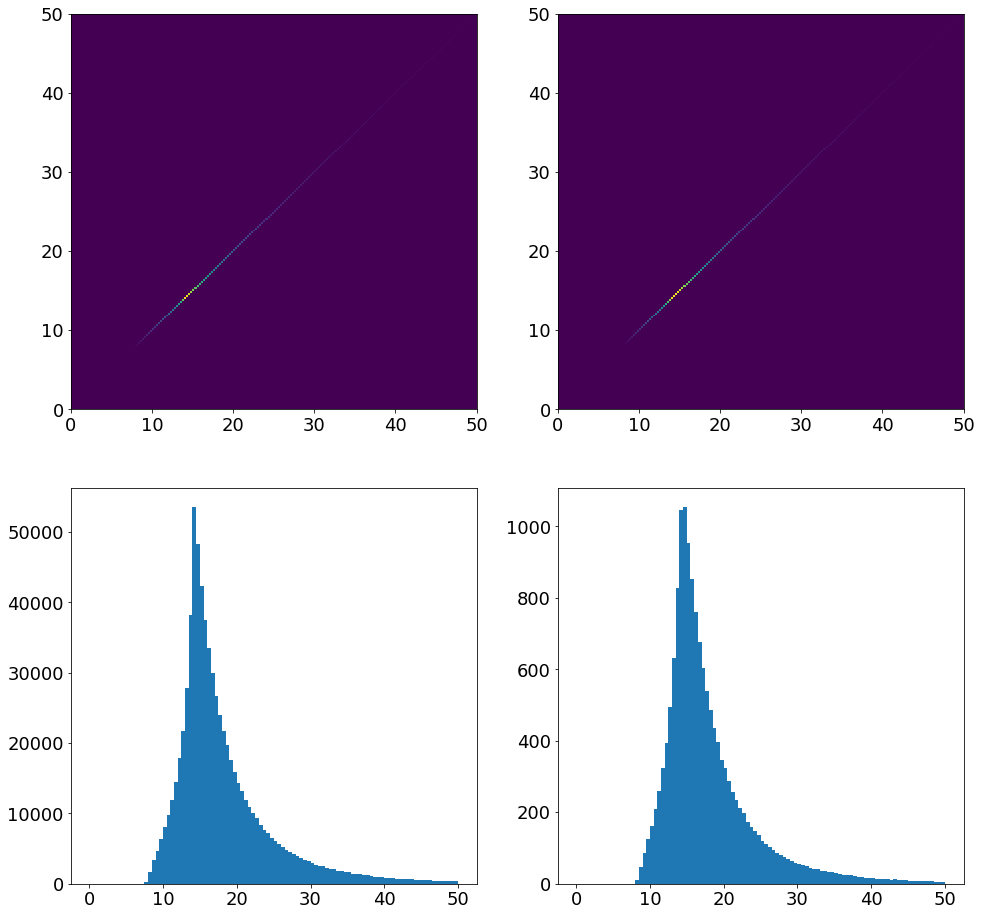

In [9]:
fix,ax = plt.subplots(2,2,figsize=(16,16))

print( 'cuts : %s' % cuts )

ax[0][0].hist2d( mc.query(cuts)['gen_e_pt'], mc.query(cuts)['T__gen_e'], range=([0,50],[0,50]), bins=200)
ax[0][1].hist2d( mc_fullsim.query(cuts)['gen_e_pt'], mc_fullsim.query(cuts)['T__gen_e'], weights=mc_fullsim.query(cuts)['wgt'], range=([0,50],[0,50]), bins=200)

ax[1][0].hist( mc.query(cuts)['gen_e_pt'], range=[0,50], bins=100) 
ax[1][1].hist( mc_fullsim.query(cuts)['gen_e_pt'], weights=mc_fullsim.query(cuts)['wgt'], range=[0,50], bins=100) 

plt.show()

cuts : gen_y < 0.7


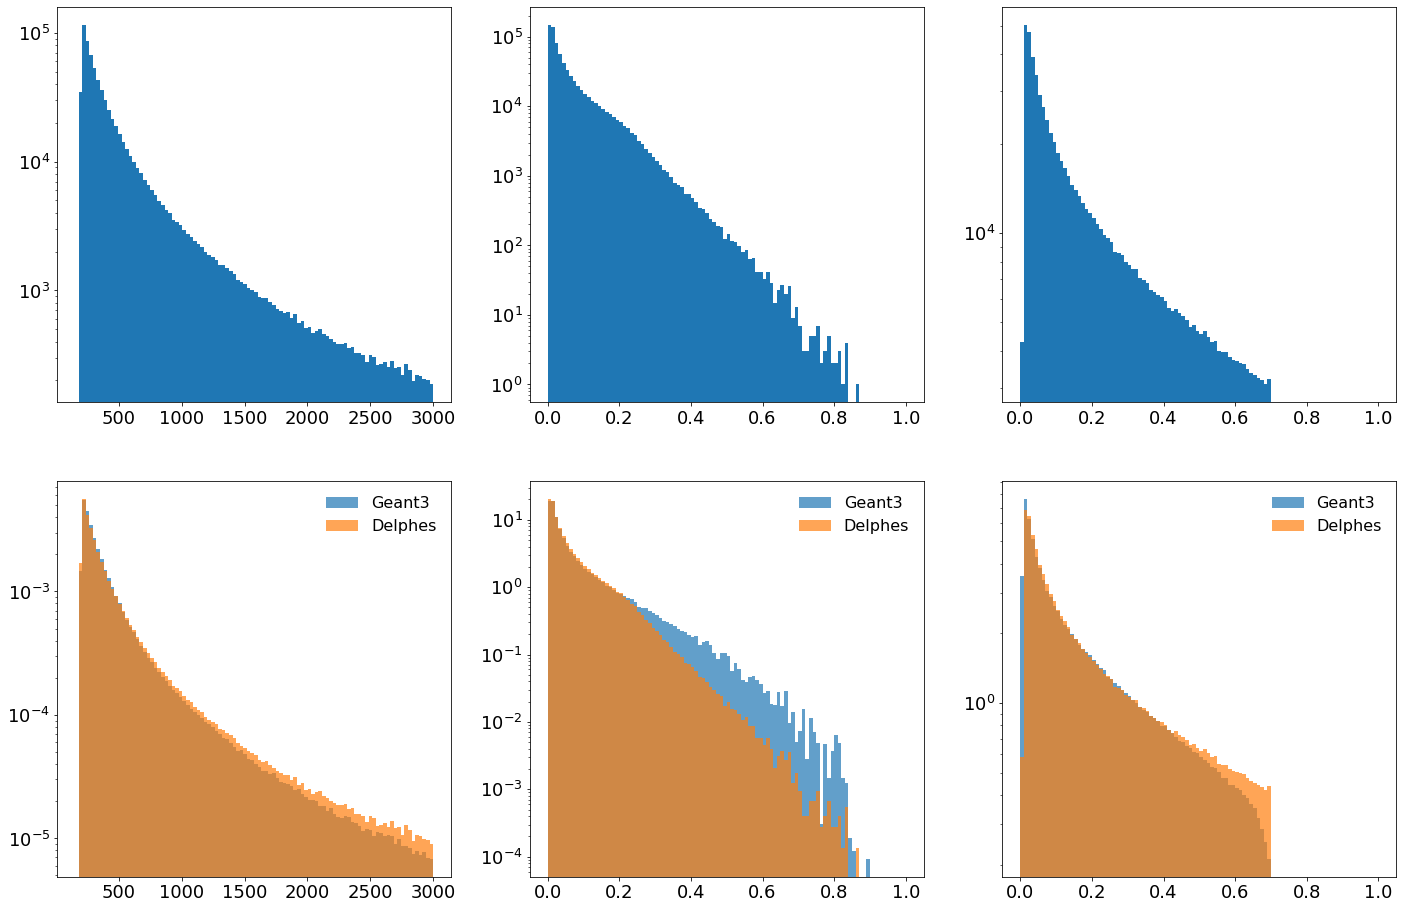

In [10]:
fig,ax = plt.subplots(2,3,figsize=(24,16))

print( 'cuts : %s' % cuts )

ax[0][0].hist( mc.query(cuts)['gen_Q2'], range=[150,3000], bins=100 )
ax[0][1].hist( mc.query(cuts)['gen_x'], range=[0,1], bins=100 )
ax[0][2].hist( mc.query(cuts)['gen_y'], range=[0,1], bins=100 )

ax[1][0].hist( mc_fullsim.query(cuts)['gen_Q2'], weights=mc_fullsim.query(cuts)['wgt'], range=[150,3000], bins=100, density=True, alpha=0.7, label='Geant3' )
ax[1][1].hist( mc_fullsim.query(cuts)['gen_x'], weights=mc_fullsim.query(cuts)['wgt'], range=[0,1], bins=100, density=True, alpha=0.7, label='Geant3' )
ax[1][2].hist( mc_fullsim.query(cuts)['gen_y'], weights=mc_fullsim.query(cuts)['wgt'], range=[0,1], bins=100, density=True, alpha=0.7, label='Geant3' )
ax[1][0].hist( mc.query(cuts)['gen_Q2'], range=[150,3000], bins=100, density=True, alpha=0.7, label='Delphes' )
ax[1][1].hist( mc.query(cuts)['gen_x'], range=[0,1], bins=100, density=True, alpha=0.7, label='Delphes' )
ax[1][2].hist( mc.query(cuts)['gen_y'], range=[0,1], bins=100, density=True, alpha=0.7, label='Delphes' )


ax[0][0].set_yscale('log')
ax[0][1].set_yscale('log')
ax[0][2].set_yscale('log')
ax[1][0].set_yscale('log')
ax[1][1].set_yscale('log')
ax[1][2].set_yscale('log')

ax[1][0].legend(loc='best',fontsize=16)
ax[1][1].legend(loc='best',fontsize=16)
ax[1][2].legend(loc='best',fontsize=16)


plt.show()

## 2D plots of HFS vars, measured vs True, derived from true scattered electron

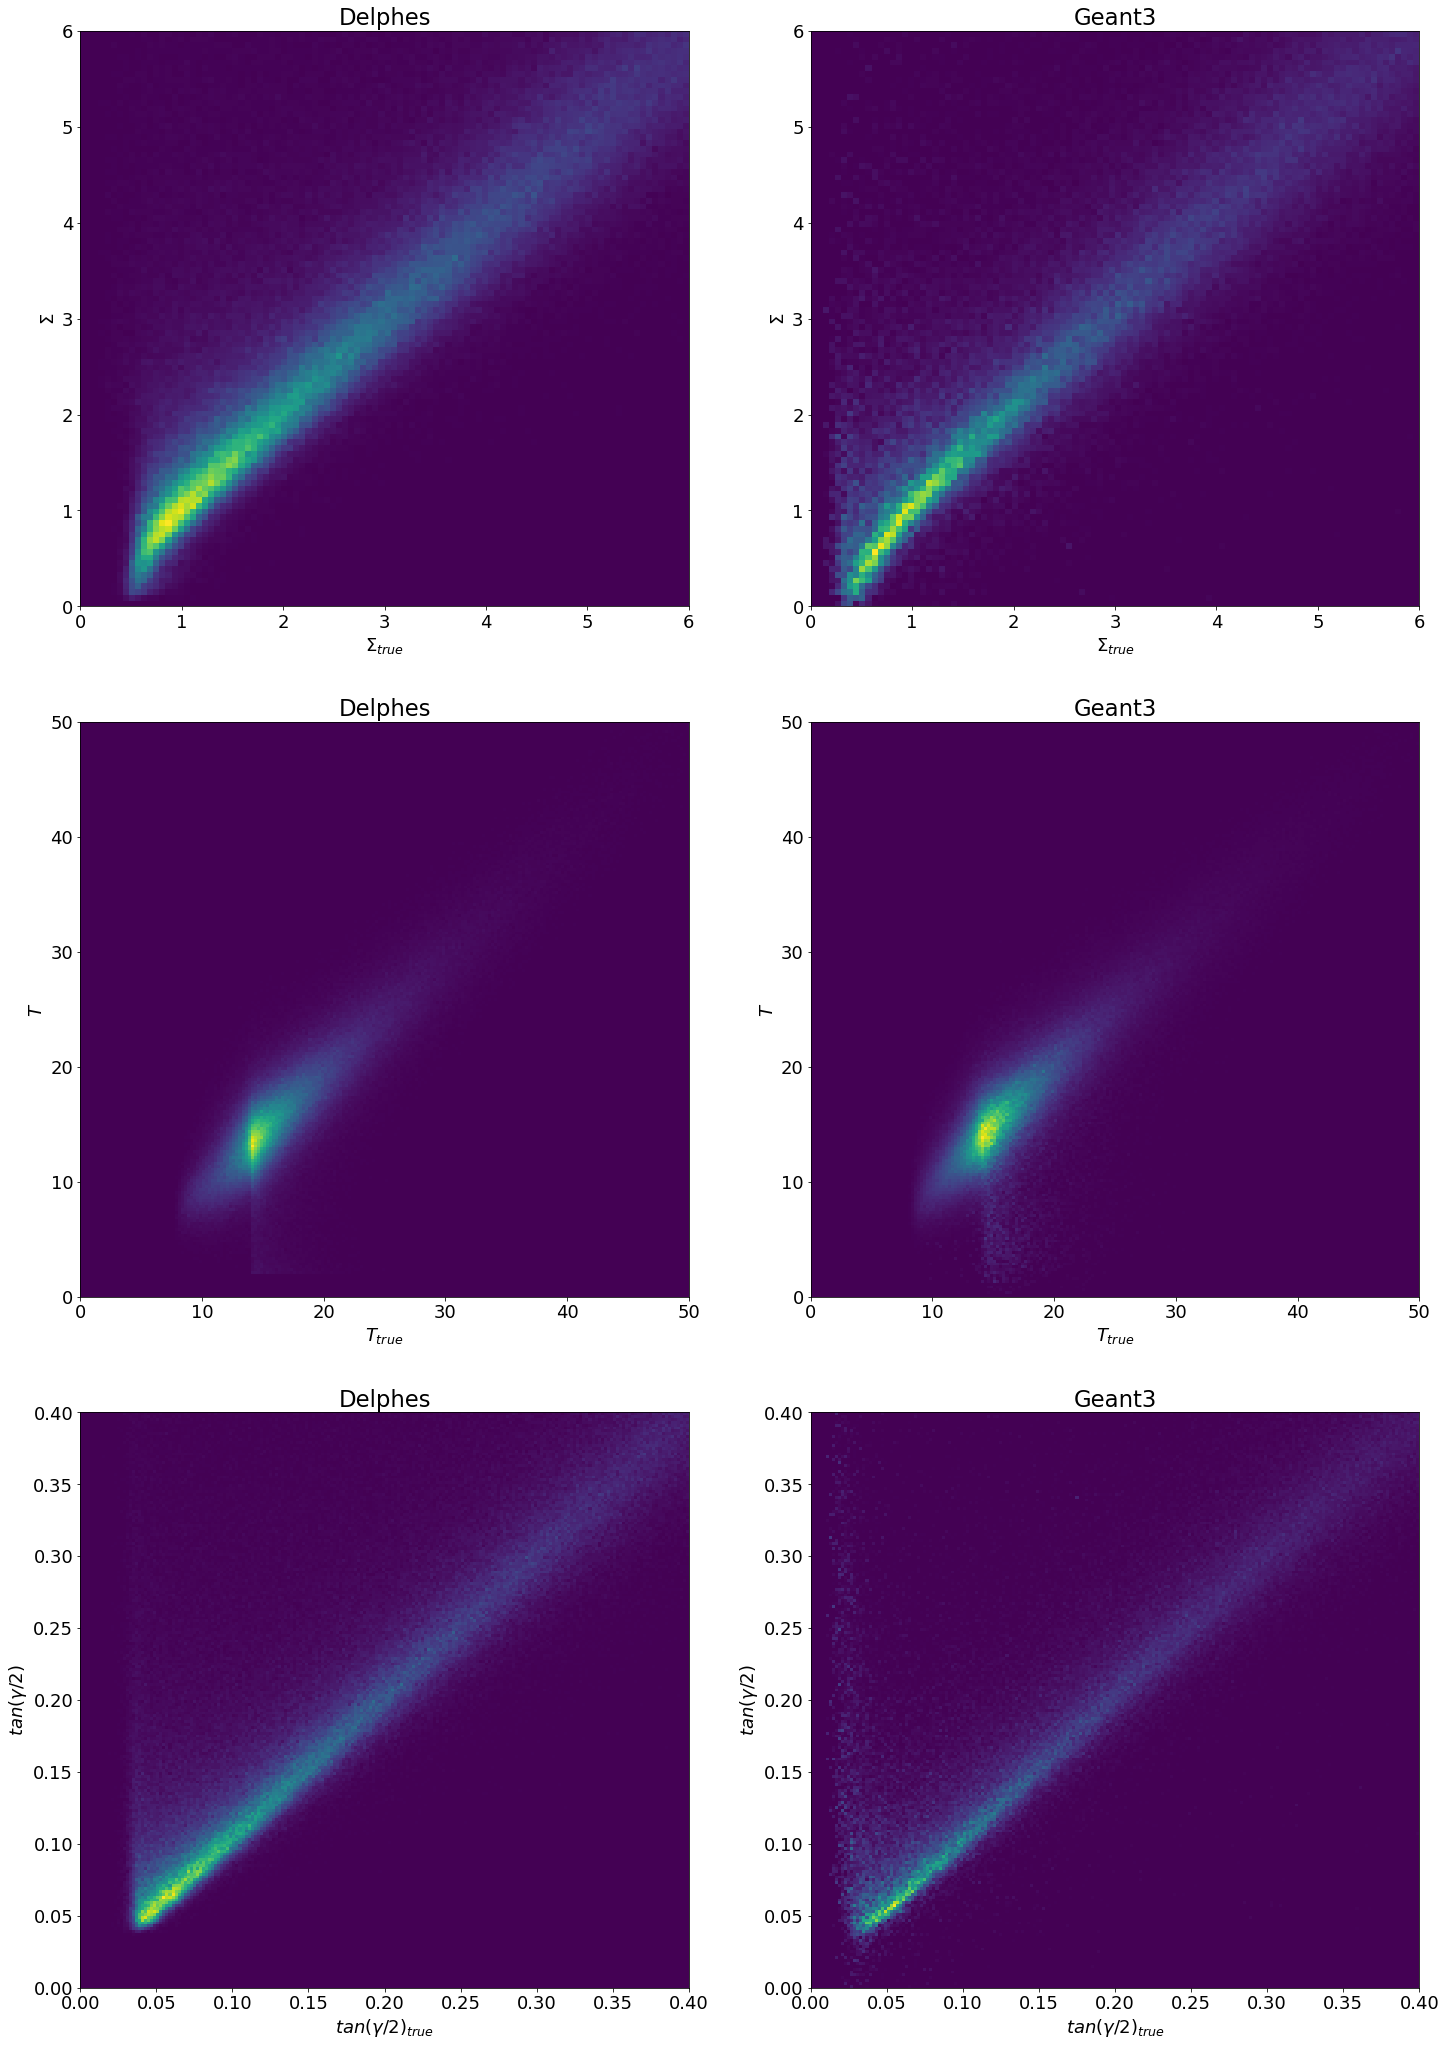

In [11]:
cuts = 'gen_y < 0.7'

fig,ax = plt.subplots(3,2,figsize=(24,36))

ax[0][0].set_title('Delphes')
#ax[0][0].hist2d( mc.query(cuts)['Sigma__gen_e'], mc.query(cuts)['Sigma__HFS'], range=([0,10],[0,10]), bins=200)
ax[0][0].hist2d( mc.query(cuts)['Sigma__gen_e'], mc.query(cuts)['Sigma__HFS'], range=([0,6],[0,6]), bins=100)
ax[0][0].set_xlabel('$\Sigma_{true}$')
ax[0][0].set_ylabel('$\Sigma$')

ax[1][0].set_title('Delphes')
ax[1][0].hist2d( mc.query(cuts)['T__gen_e'], mc.query(cuts)['T__HFS'], range=([0,50],[0,50]), bins=200)
#ax[1][0].hist2d( mc.query(cuts)['T__gen_HFS'], mc.query(cuts)['T__HFS'], range=([0,50],[0,50]), bins=200)
ax[1][0].set_xlabel('$T_{true}$')
ax[1][0].set_ylabel('$T$')

ax[2][0].set_title('Delphes')
ax[2][0].hist2d( mc.query(cuts)['tan_gamma_over_2__gen_e'], mc.query(cuts)['tan_gamma_over_2__HFS'], range=([0,0.4],[0,0.4]), bins=200)
ax[2][0].set_xlabel('$tan(\gamma/2)_{true}$')
ax[2][0].set_ylabel('$tan(\gamma/2)$')


#ax[3][0].set_title('Delphes')
#ax[3][0].hist2d( mc.query(cuts)['gen_HFS_e'], mc.query(cuts)['HFS_E'], range=([0,500],[0,500]), bins=200)
#ax[3][0].set_xlabel('$HFS_{E,true}$')
#ax[3][0].set_ylabel('$HFS_E$')


thisdf = mc_fullsim

ax[0][1].set_title('Geant3')
#ax[0][1].hist2d( thisdf.query(cuts)['Sigma__gen_e'], thisdf.query(cuts)['Sigma__HFS'], weights=thisdf.query(cuts)['wgt'], range=([0,10],[0,10]), bins=200)
ax[0][1].hist2d( thisdf.query(cuts)['Sigma__gen_e'], thisdf.query(cuts)['Sigma__HFS'], weights=thisdf.query(cuts)['wgt'], range=([0,6],[0,6]), bins=100)
ax[0][1].set_xlabel('$\Sigma_{true}$')
ax[0][1].set_ylabel('$\Sigma$')

ax[1][1].set_title('Geant3')
ax[1][1].hist2d( thisdf.query(cuts)['T__gen_e'], thisdf.query(cuts)['T__HFS'], weights=thisdf.query(cuts)['wgt'], range=([0,50],[0,50]), bins=200)
#ax[1][1].hist2d( thisdf.query(cuts)['T__gen_HFS'], thisdf.query(cuts)['T__HFS'], weights=thisdf.query(cuts)['wgt'], range=([0,50],[0,50]), bins=200)
ax[1][1].set_xlabel('$T_{true}$')
ax[1][1].set_ylabel('$T$')

ax[2][1].set_title('Geant3')
ax[2][1].hist2d( thisdf.query(cuts)['tan_gamma_over_2__gen_e'], thisdf.query(cuts)['tan_gamma_over_2__HFS'], weights=thisdf.query(cuts)['wgt'], range=([0,0.4],[0,0.4]), bins=200)
ax[2][1].set_xlabel('$tan(\gamma/2)_{true}$')
ax[2][1].set_ylabel('$tan(\gamma/2)$')


#ax[3][1].set_title('Geant3')
#ax[3][1].hist2d( thisdf.query(cuts)['gen_HFS_e'], thisdf.query(cuts)['HFS_E'], weights=thisdf.query(cuts)['wgt'], range=([0,500],[0,500]), bins=200)
#ax[3][1].set_xlabel('$HFS_{E,true}$')
#ax[3][1].set_ylabel('$HFS_E$')

plt.show()

## HFS Sigma resolution

 bin 0 : gen_y>0.5 and gen_y<0.7
 bin 1 : gen_y>0.2 and gen_y<0.5
 bin 2 : gen_y>0.1 and gen_y<0.2
 bin 3 : gen_y>0.05 and gen_y<0.1
 bin 4 : gen_y>0.01 and gen_y<0.05


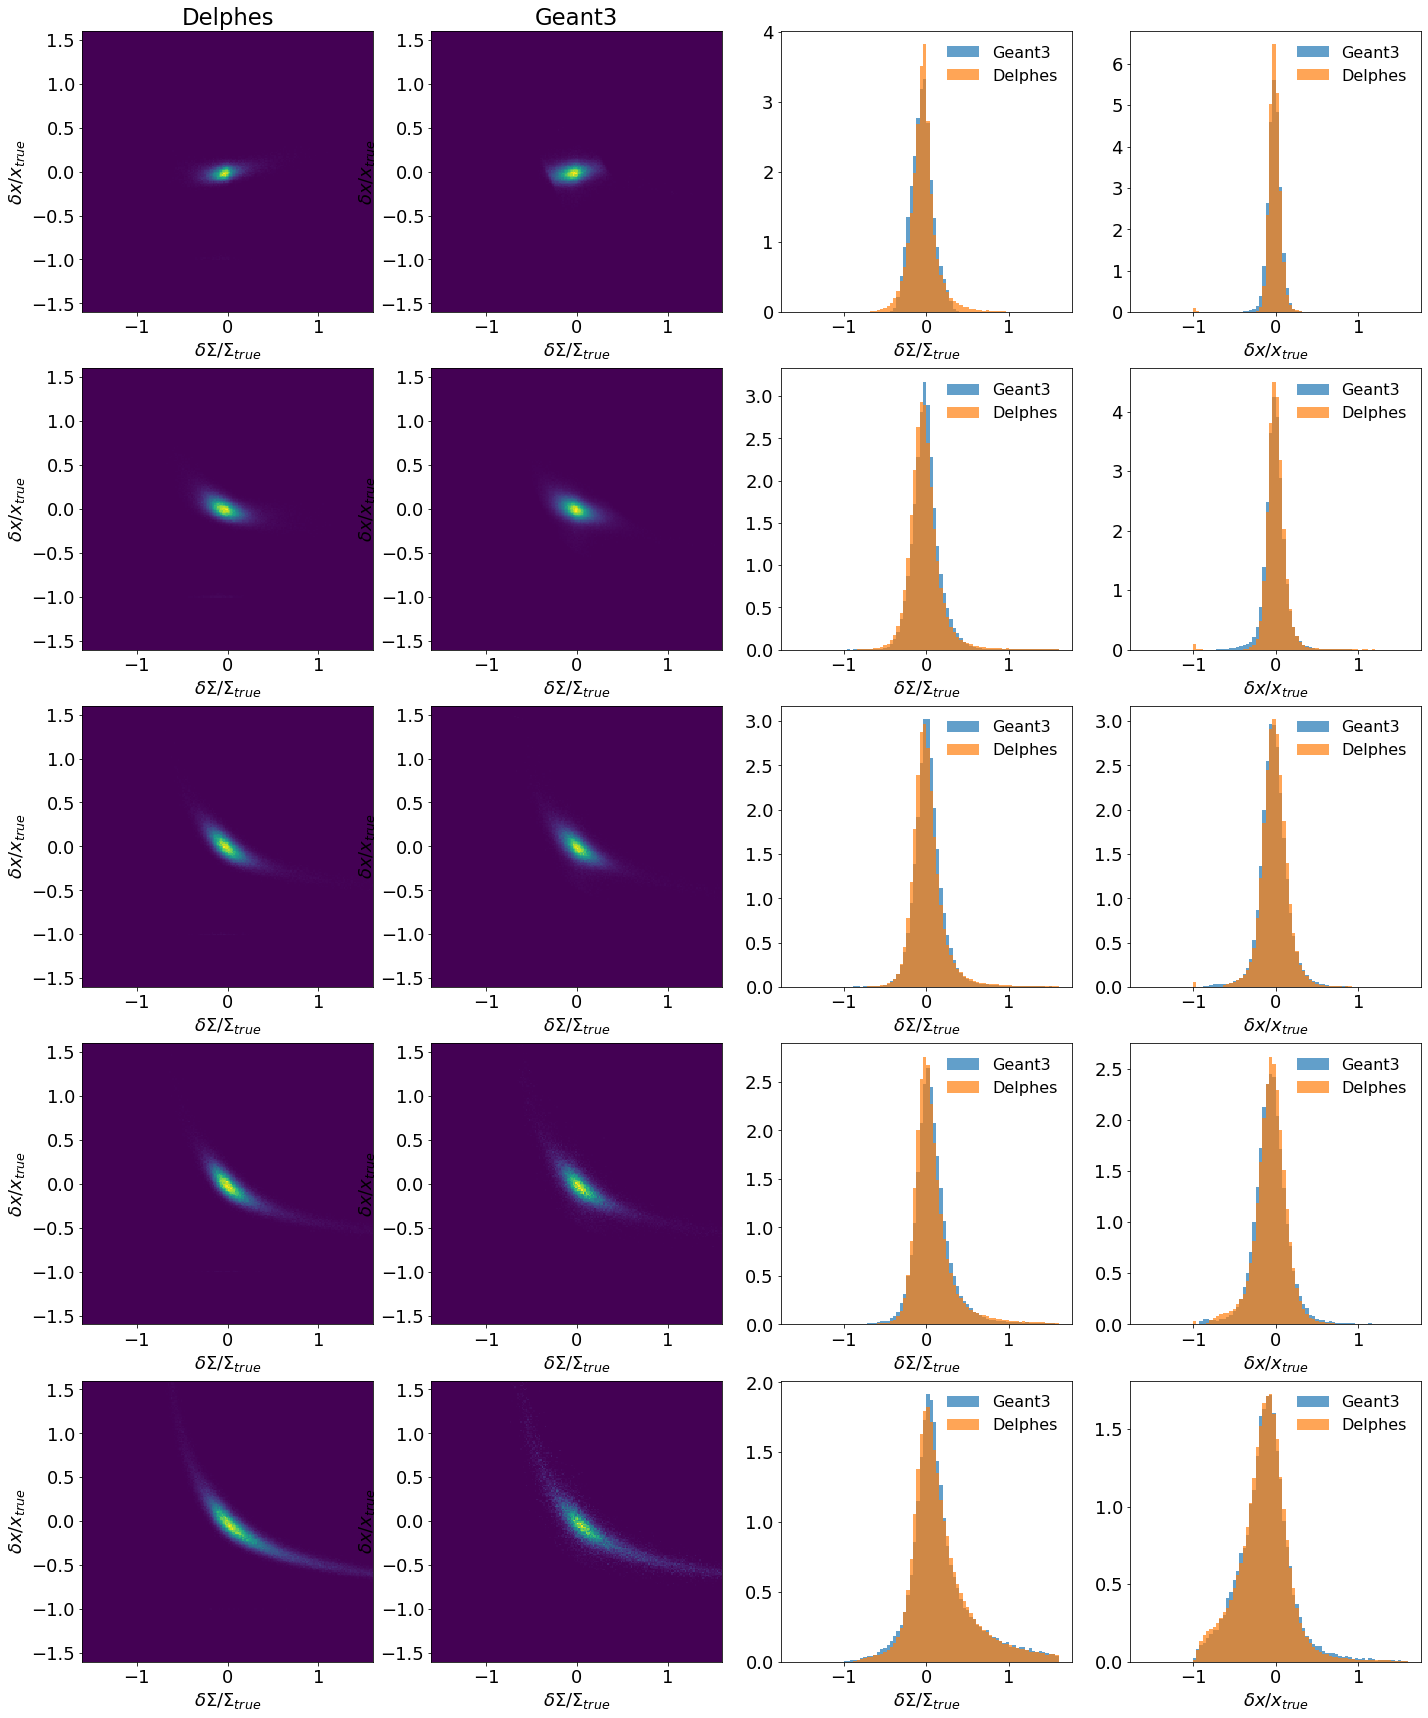

In [12]:
fix,ax = plt.subplots(5,4,figsize=(24,30))

ybins = np.array(['gen_y>0.5 and gen_y<0.7', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])


for ybi in range(len(ybins)):
    
    print( ' bin %d : %s' % (ybi, ybins[ybi]))
    
    cuts = ybins[ybi]

    if ybi == 0 : ax[ybi][0].set_title('Delphes')
    ax[ybi][0].hist2d( mc.query(cuts)['dSigma_norm__gen_e'], mc.query(cuts)['dx_sigma_norm'], range = ([-1*axis_max,axis_max],[-1*axis_max,axis_max]), bins=200)
    ax[ybi][0].set_xlabel('$\delta \Sigma / \Sigma_{true}$')
    ax[ybi][0].set_ylabel('$\delta x / x_{true}$')

    if ybi == 0 : ax[ybi][1].set_title('Geant3')
    ax[ybi][1].hist2d( mc_fullsim.query(cuts)['dSigma_norm__gen_e'], mc_fullsim.query(cuts)['dx_sigma_norm'], weights=mc_fullsim.query(cuts)['wgt'], range = ([-1*axis_max,axis_max],[-1*axis_max,axis_max]), bins=200)
    ax[ybi][1].set_xlabel('$\delta \Sigma / \Sigma_{true}$')
    ax[ybi][1].set_ylabel('$\delta x / x_{true}$')

    ax[ybi][2].hist( mc_fullsim.query(cuts)['dSigma_norm__gen_e'], weights=mc_fullsim.query(cuts)['wgt'], range=[-1*axis_max,axis_max], bins=80, alpha=0.7, density=True, label='Geant3' )
    ax[ybi][2].hist( mc.query(cuts)['dSigma_norm__gen_e'], range=[-1*axis_max,axis_max], bins=80, alpha=0.7, density=True, label='Delphes' )
    ax[ybi][2].set_xlabel('$\delta \Sigma / \Sigma_{true}$')
    ax[ybi][2].legend(loc='best',fontsize=16)
    
    ax[ybi][3].hist( mc_fullsim.query(cuts)['dx_sigma_norm'], weights=mc_fullsim.query(cuts)['wgt'], range=[-1*axis_max,axis_max], bins=80, alpha=0.7, density=True, label='Geant3' )
    ax[ybi][3].hist( mc.query(cuts)['dx_sigma_norm'], range=[-1*axis_max,axis_max], bins=80, alpha=0.7, density=True, label='Delphes' )
    ax[ybi][3].set_xlabel('$\delta x / x_{true}$')
    ax[ybi][3].legend(loc='best',fontsize=16)




plt.show()

## HFS T resolution

 bin 0 : gen_y>0.5 and gen_y<0.7
 bin 1 : gen_y>0.2 and gen_y<0.5
 bin 2 : gen_y>0.1 and gen_y<0.2
 bin 3 : gen_y>0.05 and gen_y<0.1
 bin 4 : gen_y>0.01 and gen_y<0.05


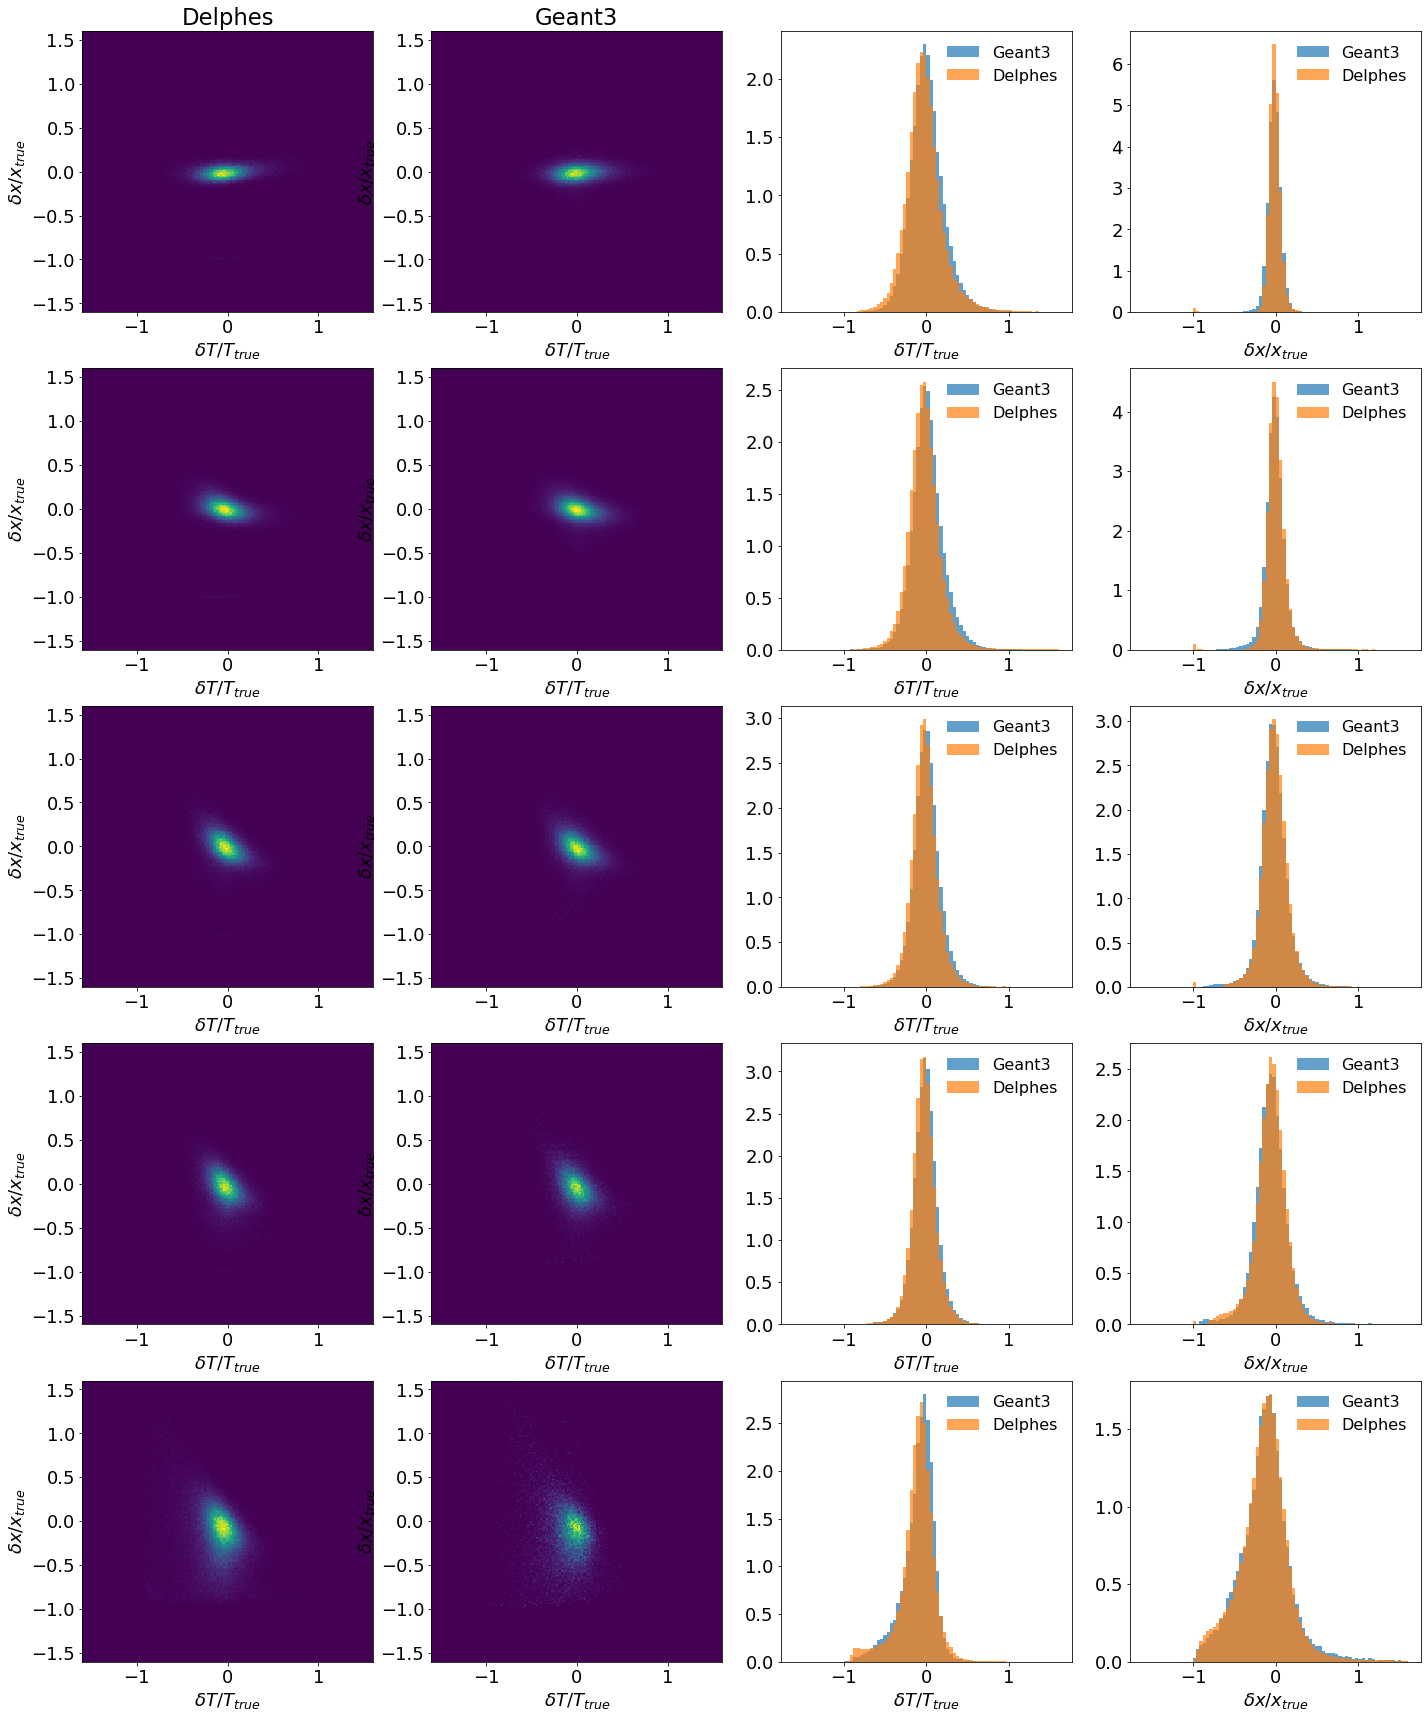

In [13]:
fix,ax = plt.subplots(5,4,figsize=(24,30))

ybins = np.array(['gen_y>0.5 and gen_y<0.7', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])


for ybi in range(len(ybins)):
    
    print( ' bin %d : %s' % (ybi, ybins[ybi]))
    
    cuts = ybins[ybi]

    if ybi == 0 : ax[ybi][0].set_title('Delphes')
    ax[ybi][0].hist2d( mc.query(cuts)['dT_norm__gen_e'], mc.query(cuts)['dx_sigma_norm'], range = ([-1*axis_max,axis_max],[-1*axis_max,axis_max]), bins=200)
    ax[ybi][0].set_xlabel('$\delta T / T_{true}$')
    ax[ybi][0].set_ylabel('$\delta x / x_{true}$')

    if ybi == 0 : ax[ybi][1].set_title('Geant3')
    ax[ybi][1].hist2d( mc_fullsim.query(cuts)['dT_norm__gen_e'], mc_fullsim.query(cuts)['dx_sigma_norm'], weights=mc_fullsim.query(cuts)['wgt'], range = ([-1*axis_max,axis_max],[-1*axis_max,axis_max]), bins=200)
    ax[ybi][1].set_xlabel('$\delta T / T_{true}$')
    ax[ybi][1].set_ylabel('$\delta x / x_{true}$')

    ax[ybi][2].hist( mc_fullsim.query(cuts)['dT_norm__gen_e'], weights=mc_fullsim.query(cuts)['wgt'], range=[-1*axis_max,axis_max], bins=80, alpha=0.7, density=True, label='Geant3' )
    ax[ybi][2].hist( mc.query(cuts)['dT_norm__gen_e'], range=[-1*axis_max,axis_max], bins=80, alpha=0.7, density=True, label='Delphes' )
    ax[ybi][2].set_xlabel('$\delta T / T_{true}$')
    ax[ybi][2].legend(loc='best',fontsize=16)

    ax[ybi][3].hist( mc_fullsim.query(cuts)['dx_sigma_norm'], weights=mc_fullsim.query(cuts)['wgt'], range=[-1*axis_max,axis_max], bins=80, alpha=0.7, density=True, label='Geant3' )
    ax[ybi][3].hist( mc.query(cuts)['dx_sigma_norm'], range=[-1*axis_max,axis_max], bins=80, alpha=0.7, density=True, label='Delphes' )
    ax[ybi][3].set_xlabel('$\delta x / x_{true}$')
    ax[ybi][3].legend(loc='best',fontsize=16)



plt.show()

## HFS $\tan(\gamma/2)$ resolution

 bin 0 : gen_y>0.5 and gen_y<0.7
 bin 1 : gen_y>0.2 and gen_y<0.5
 bin 2 : gen_y>0.1 and gen_y<0.2
 bin 3 : gen_y>0.05 and gen_y<0.1
 bin 4 : gen_y>0.01 and gen_y<0.05


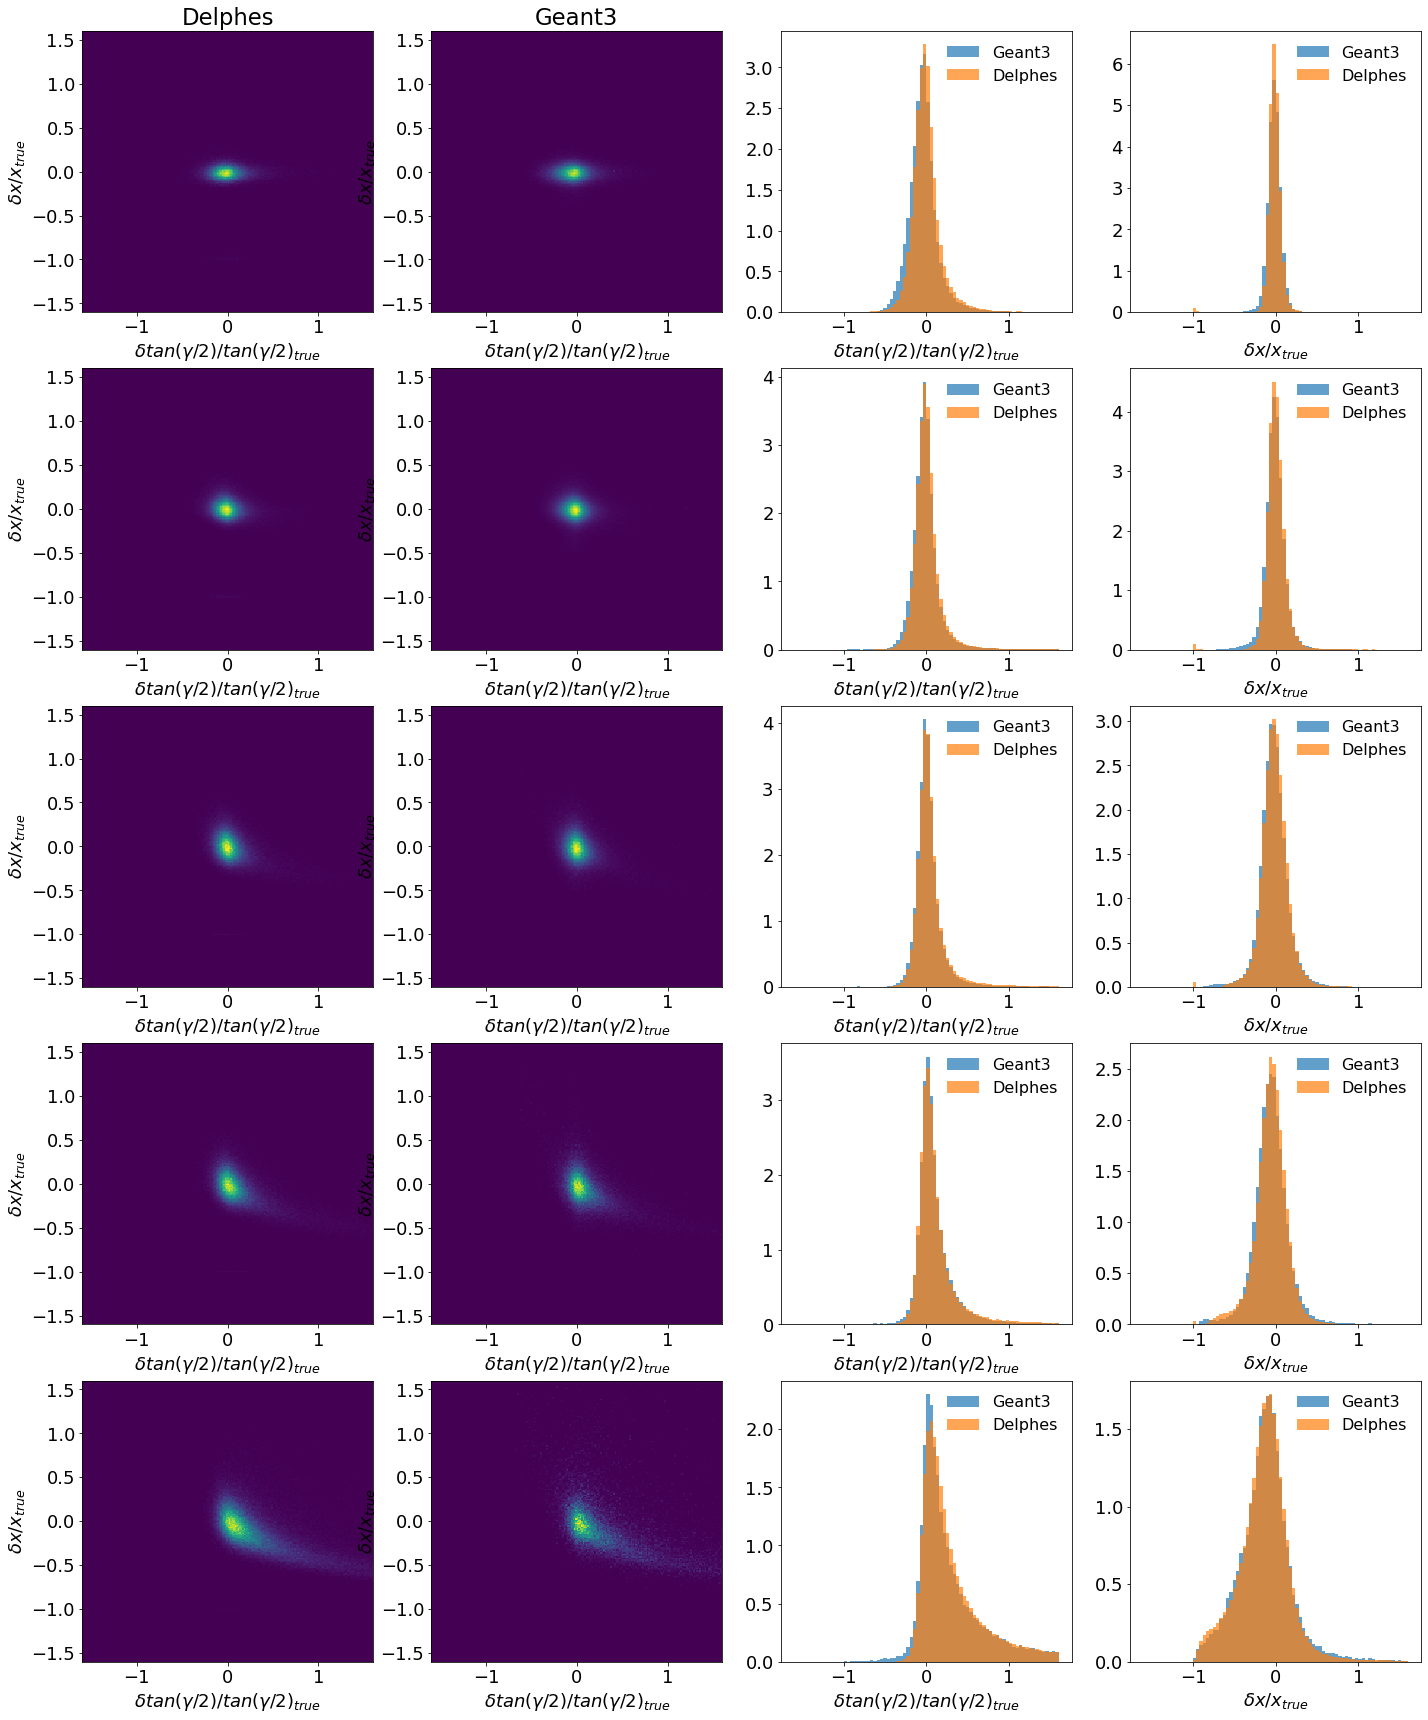

In [14]:
fix,ax = plt.subplots(5,4,figsize=(24,30))

ybins = np.array(['gen_y>0.5 and gen_y<0.7', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])


for ybi in range(len(ybins)):
    
    print( ' bin %d : %s' % (ybi, ybins[ybi]))
    
    cuts = ybins[ybi]

    if ybi == 0 : ax[ybi][0].set_title('Delphes')
    ax[ybi][0].hist2d( mc.query(cuts)['dtan_gamma_over_2_norm__gen_e'], mc.query(cuts)['dx_sigma_norm'], range = ([-1*axis_max,axis_max],[-1*axis_max,axis_max]), bins=200)
    ax[ybi][0].set_xlabel('$\delta tan(\gamma/2) / tan(\gamma/2)_{true}$')
    ax[ybi][0].set_ylabel('$\delta x / x_{true}$')

    if ybi == 0 : ax[ybi][1].set_title('Geant3')
    ax[ybi][1].hist2d( mc_fullsim.query(cuts)['dtan_gamma_over_2_norm__gen_e'], mc_fullsim.query(cuts)['dx_sigma_norm'], weights=mc_fullsim.query(cuts)['wgt'], range = ([-1*axis_max,axis_max],[-1*axis_max,axis_max]), bins=200)
    ax[ybi][1].set_xlabel('$\delta tan(\gamma/2) / tan(\gamma/2)_{true}$')
    ax[ybi][1].set_ylabel('$\delta x / x_{true}$')

    ax[ybi][2].hist( mc_fullsim.query(cuts)['dtan_gamma_over_2_norm__gen_e'], weights=mc_fullsim.query(cuts)['wgt'], range=[-1*axis_max,axis_max], bins=80, alpha=0.7, density=True, label='Geant3' )
    ax[ybi][2].hist( mc.query(cuts)['dtan_gamma_over_2_norm__gen_e'], range=[-1*axis_max,axis_max], bins=80, alpha=0.7, density=True, label='Delphes' )
    ax[ybi][2].set_xlabel('$\delta tan(\gamma/2) / tan(\gamma/2)_{true}$')
    ax[ybi][2].legend(loc='best',fontsize=16)

    ax[ybi][3].hist( mc_fullsim.query(cuts)['dx_sigma_norm'], weights=mc_fullsim.query(cuts)['wgt'], range=[-1*axis_max,axis_max], bins=80, alpha=0.7, density=True, label='Geant3' )
    ax[ybi][3].hist( mc.query(cuts)['dx_sigma_norm'], range=[-1*axis_max,axis_max], bins=80, alpha=0.7, density=True, label='Delphes' )
    ax[ybi][3].set_xlabel('$\delta x / x_{true}$')
    ax[ybi][3].legend(loc='best',fontsize=16)



plt.show()

## Stuff that depends on HFS_pz (only fastsim for now)

 bin 0 : gen_y>0.5 and gen_y<0.7
 bin 1 : gen_y>0.2 and gen_y<0.5
 bin 2 : gen_y>0.1 and gen_y<0.2
 bin 3 : gen_y>0.05 and gen_y<0.1
 bin 4 : gen_y>0.01 and gen_y<0.05


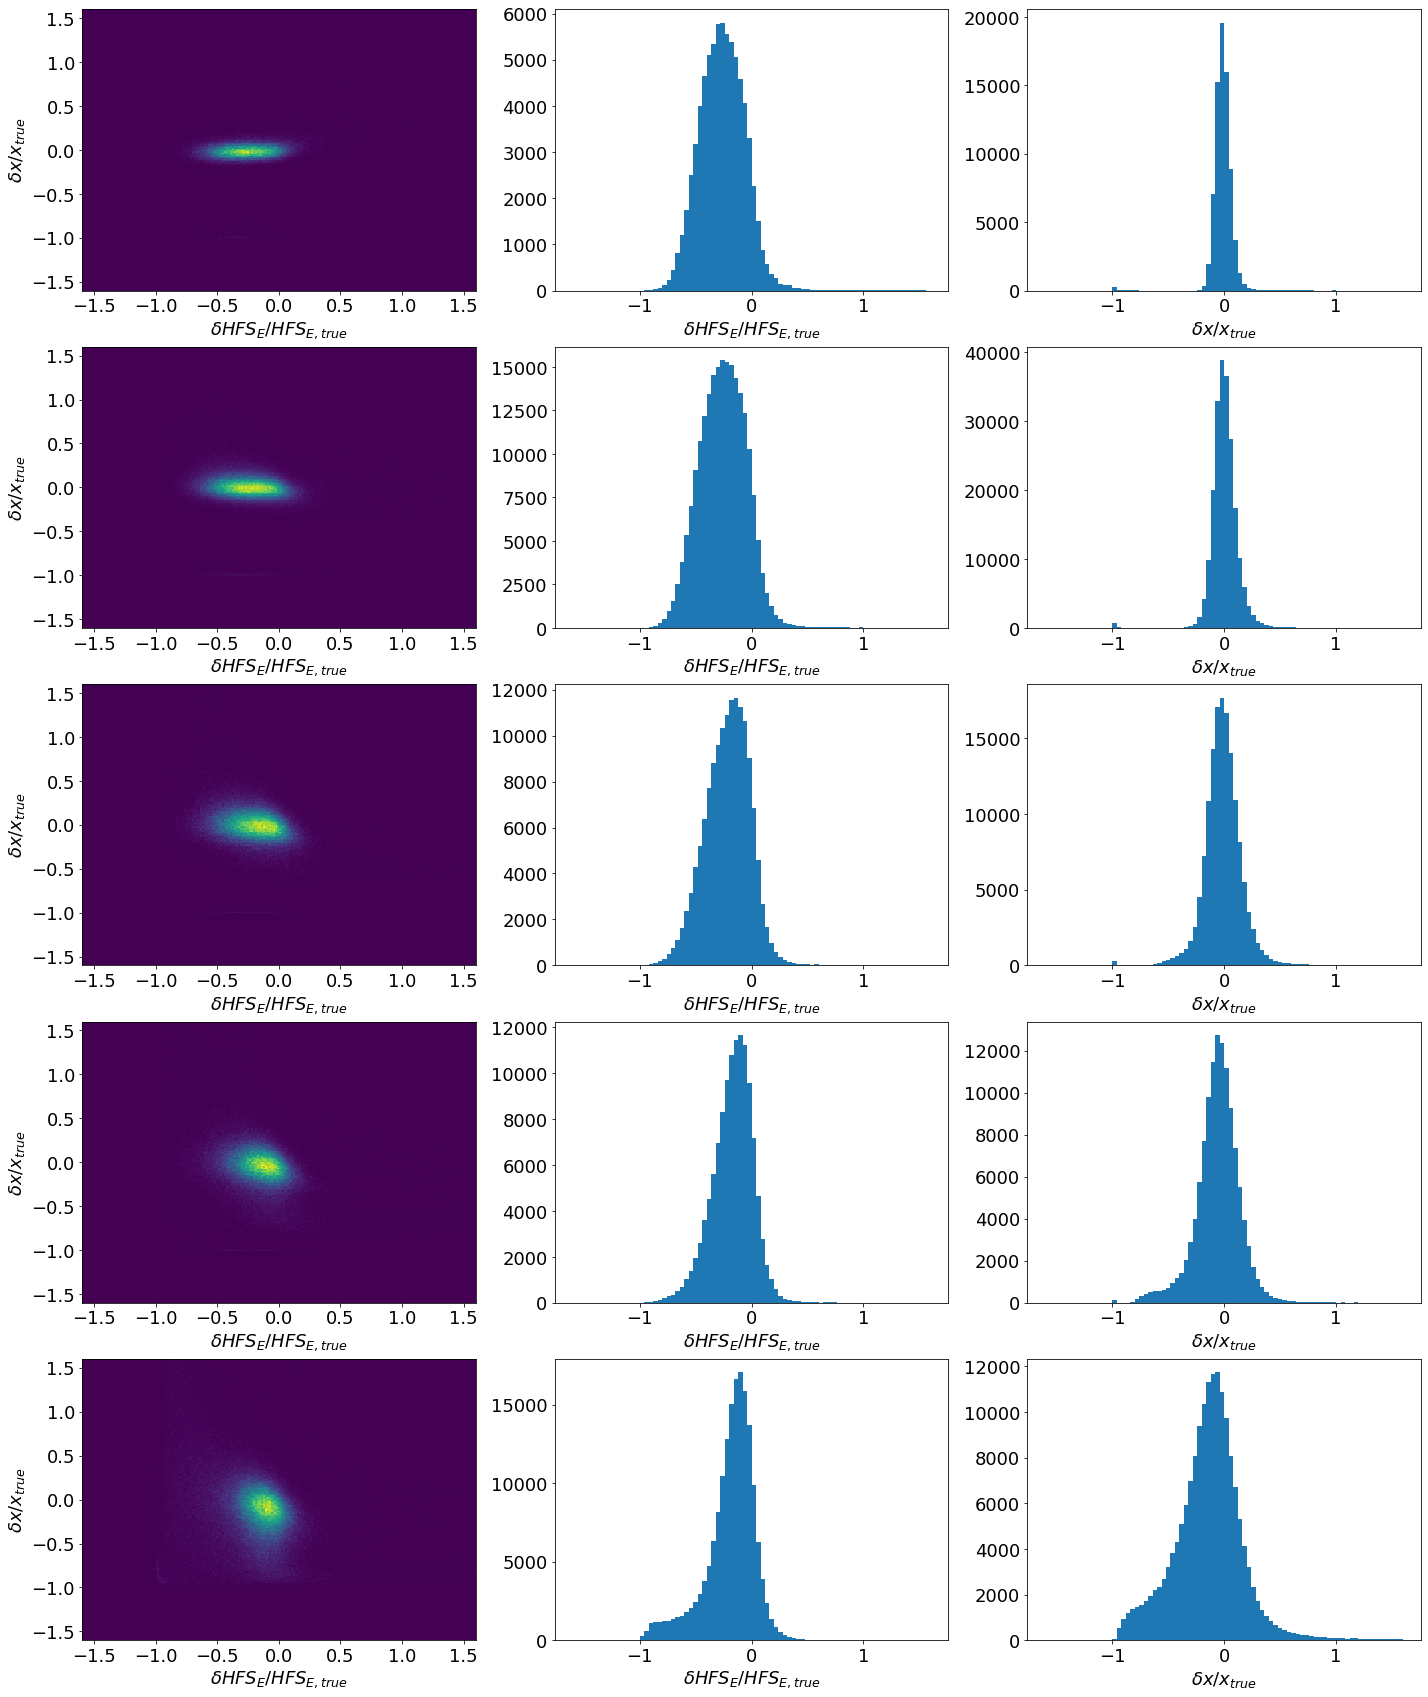

In [15]:
fix,ax = plt.subplots(5,3,figsize=(24,30))

ybins = np.array(['gen_y>0.5 and gen_y<0.7', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])


for ybi in range(len(ybins)):
    
    print( ' bin %d : %s' % (ybi, ybins[ybi]))
    
    cuts = ybins[ybi]

    ax[ybi][0].hist2d( mc.query(cuts)['dHFS_E_norm__gen_HFS'], mc.query(cuts)['dx_sigma_norm'], range = ([-1*axis_max,axis_max],[-1*axis_max,axis_max]), bins=200)
    ax[ybi][0].set_xlabel('$\delta HFS_{E} / HFS_{E,true}$')
    ax[ybi][0].set_ylabel('$\delta x / x_{true}$')

    ax[ybi][1].hist( mc.query(cuts)['dHFS_E_norm__gen_HFS'], range=[-1*axis_max,axis_max], bins=80 )
    ax[ybi][1].set_xlabel('$\delta HFS_{E} / HFS_{E,true}$')

    ax[ybi][2].hist( mc.query(cuts)['dx_sigma_norm'], range=[-1*axis_max,axis_max], bins=80 )
    ax[ybi][2].set_xlabel('$\delta x / x_{true}$')

plt.show()

 bin 0 : gen_y>0.5 and gen_y<0.7
 bin 1 : gen_y>0.2 and gen_y<0.5
 bin 2 : gen_y>0.1 and gen_y<0.2
 bin 3 : gen_y>0.05 and gen_y<0.1
 bin 4 : gen_y>0.01 and gen_y<0.05


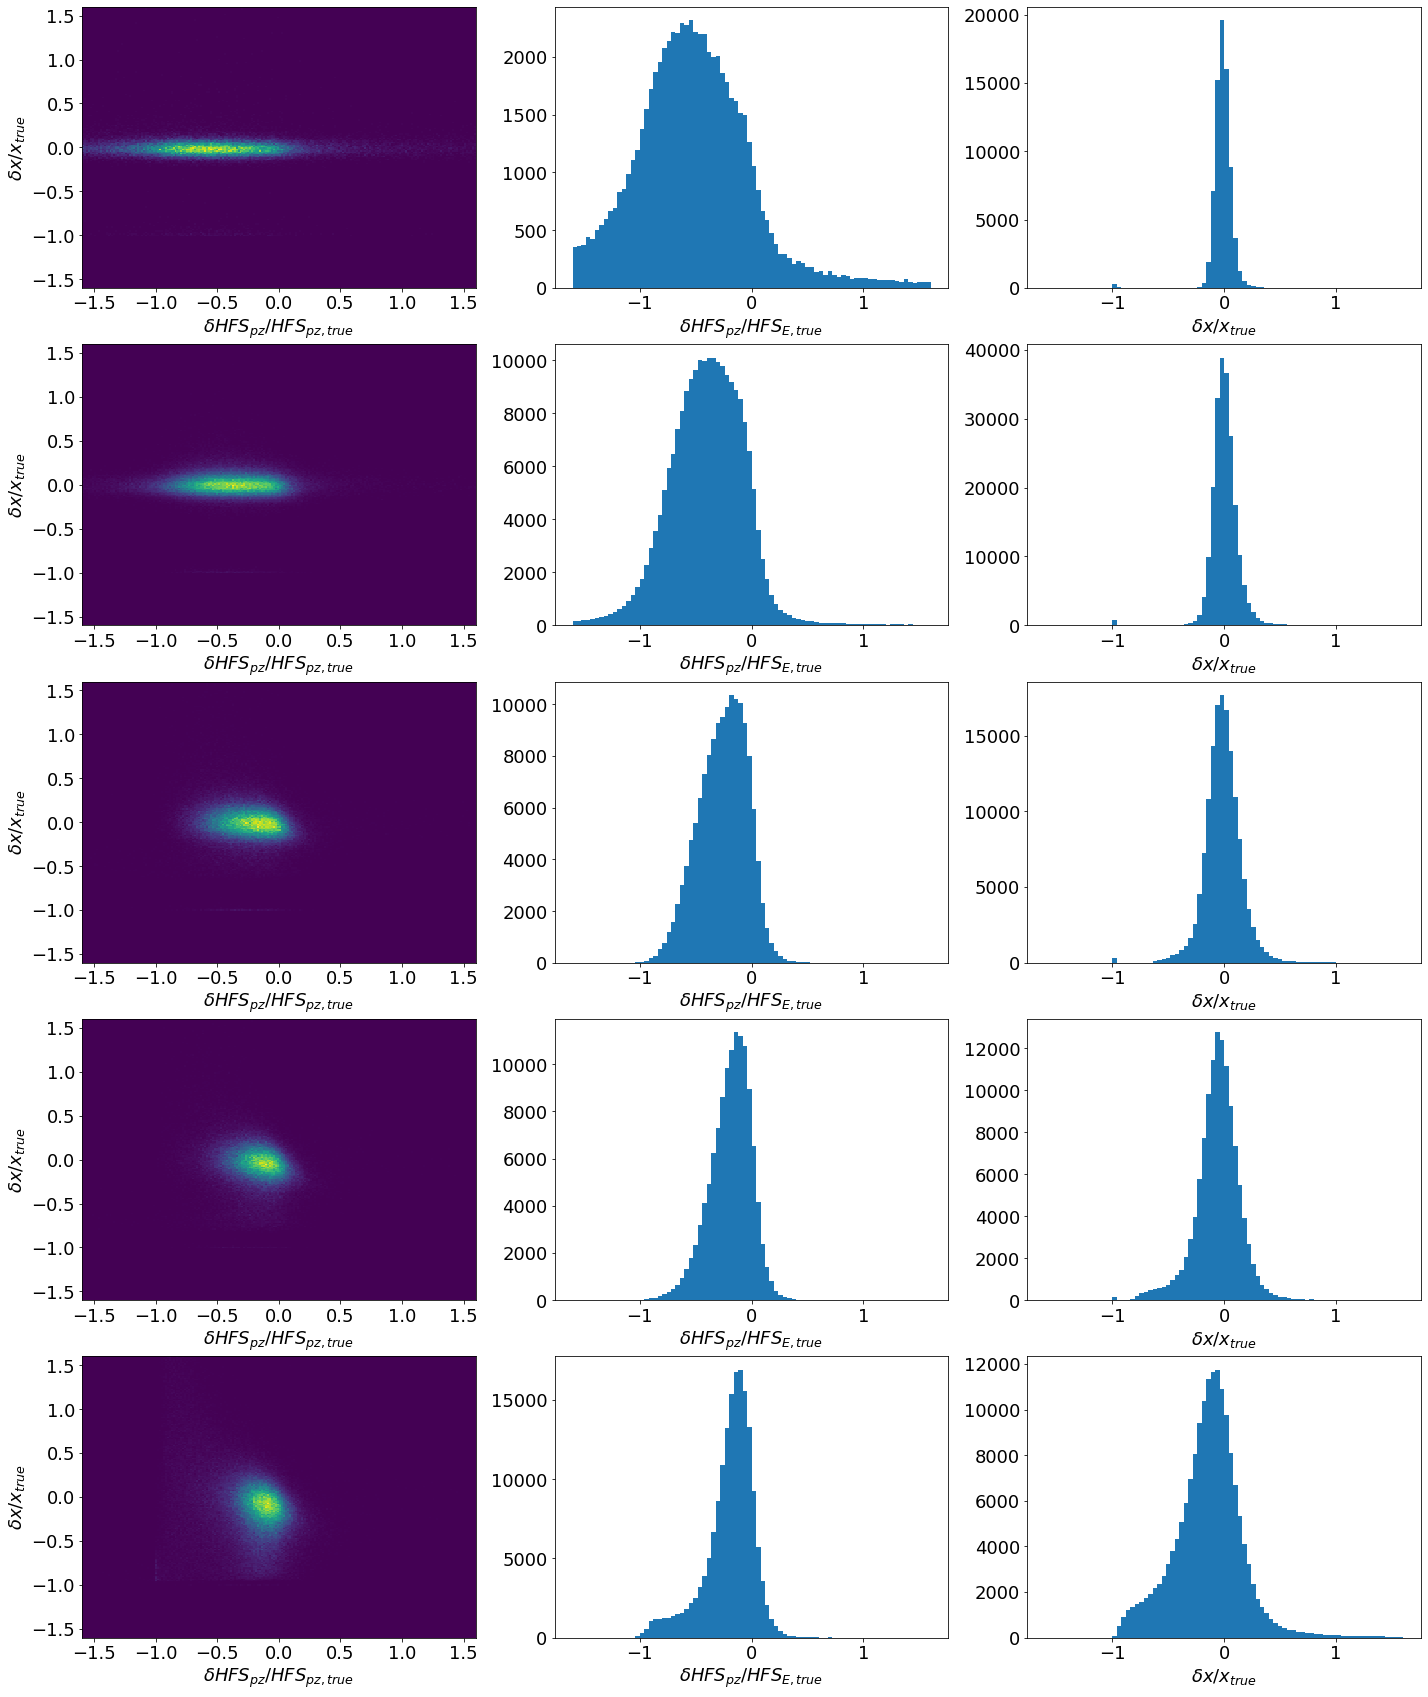

In [16]:
fix,ax = plt.subplots(5,3,figsize=(24,30))

ybins = np.array(['gen_y>0.5 and gen_y<0.7', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])


for ybi in range(len(ybins)):
    
    print( ' bin %d : %s' % (ybi, ybins[ybi]))
    
    cuts = ybins[ybi]

    ax[ybi][0].hist2d( mc.query(cuts)['dHFS_pz_norm__gen_HFS'], mc.query(cuts)['dx_sigma_norm'], range = ([-1*axis_max,axis_max],[-1*axis_max,axis_max]), bins=200)
    ax[ybi][0].set_xlabel('$\delta HFS_{pz} / HFS_{pz,true}$')
    ax[ybi][0].set_ylabel('$\delta x / x_{true}$')

    ax[ybi][1].hist( mc.query(cuts)['dHFS_pz_norm__gen_HFS'], range=[-1*axis_max,axis_max], bins=80 )
    ax[ybi][1].set_xlabel('$\delta HFS_{pz} / HFS_{E,true}$')

    ax[ybi][2].hist( mc.query(cuts)['dx_sigma_norm'], range=[-1*axis_max,axis_max], bins=80 )
    ax[ybi][2].set_xlabel('$\delta x / x_{true}$')

plt.show()